In [347]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("Blunomy")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

### Reading in the data, cleaning it and then visualising it

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

difficulty = ['easy', 'medium', 'hard', 'extrahard']
choose_difficulty = random.randint(0, 3)

lidar_df = spark.read.parquet(f'lidar_cable/lidar_cable_points_{difficulty[choose_difficulty]}.parquet')
lidar_df = lidar_df.drop('__index_level_0__')
lidar_pd = lidar_df.toPandas()

lidar_pd.head()

,x,y,z
0,6.037626,-13.231044,10.527397
1,-10.721094,17.124476,10.943132
2,2.893274,-3.527691,10.035204
3,5.870610,-10.909318,10.419144
4,-7.155748,12.846815,10.556583


### Removing duplicates, and any missing values

In [349]:
lidar_pd = lidar_pd.drop_duplicates(keep="first")
lidar_pd.dropna(inplace=True)
lidar_pd.head()

,x,y,z
0,6.037626,-13.231044,10.527397
1,-10.721094,17.124476,10.943132
2,2.893274,-3.527691,10.035204
3,5.870610,-10.909318,10.419144
4,-7.155748,12.846815,10.556583


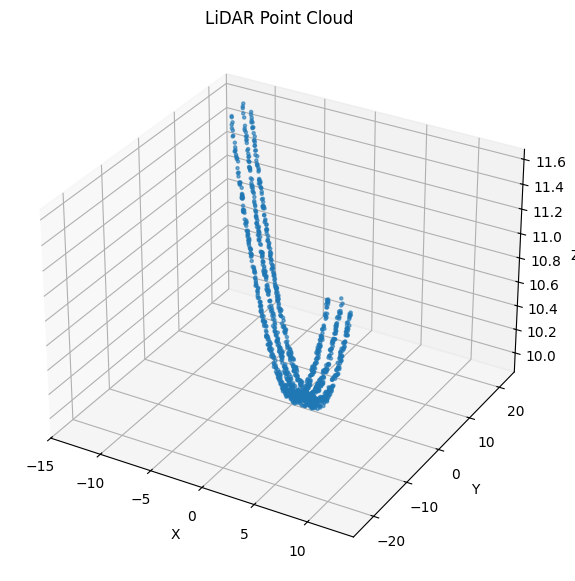

In [350]:
from lidar_functions.plot_functions import xyz_3d_plot
xyz_3d_plot(lidar_pd)

### Clustering the different groups of wires into cables

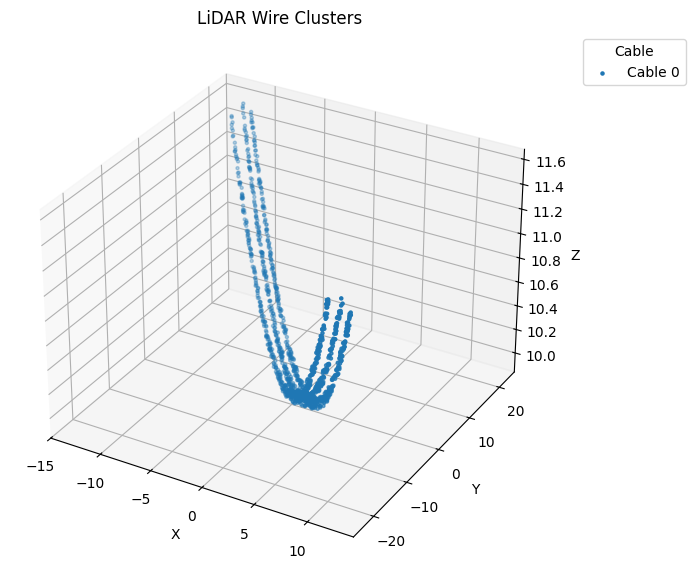

In [351]:
from lidar_functions.cluster_functions import cluster_cables
cluster_cables(lidar_pd)

### Removing noise from the data

In [352]:
lidar_pd.drop(lidar_pd[lidar_pd['cable'] == -1].index, inplace = True)

### Plotting the Cables onto an XY Plane

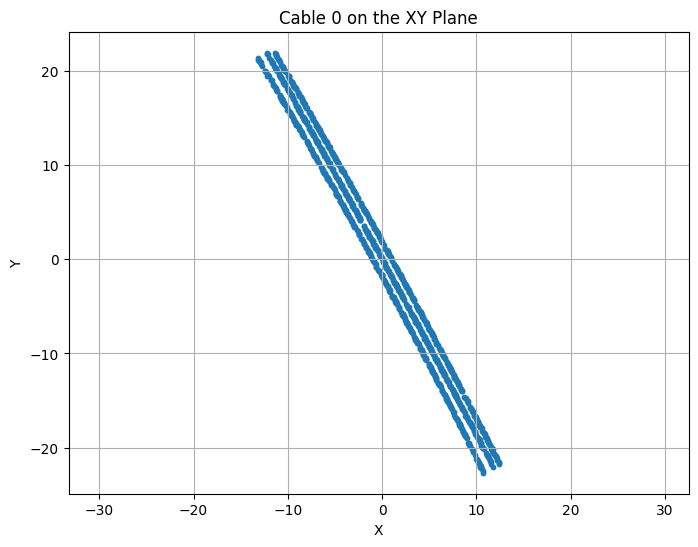

In [353]:
from lidar_functions.plot_functions import xy_cable_plot

for label in np.unique(lidar_pd['cable']):
    cable_points = lidar_pd[lidar_pd['cable'] == label]
    xy_cable_plot(cable_points, label)

### Clustering the individual wires from each cable

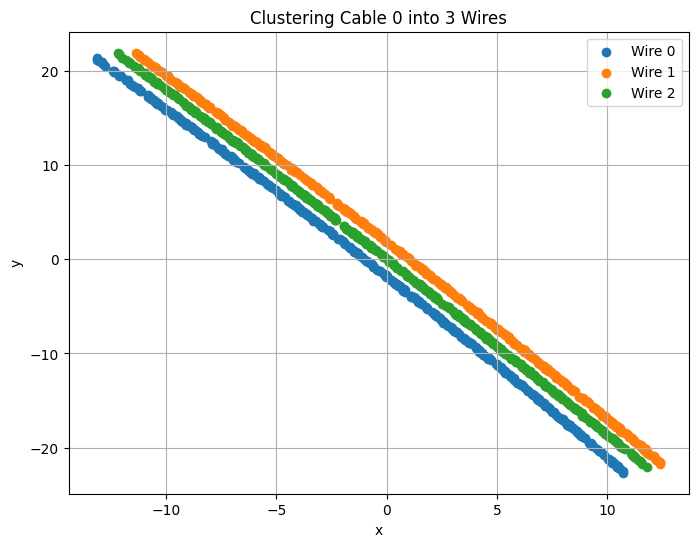

In [354]:
from lidar_functions.cluster_functions import clustering_individual_wires

combined_lidar = None
for label in np.unique(lidar_pd['cable']):

    cable_points = lidar_pd[lidar_pd['cable'] == label]
    combined_lidar = pd.concat([combined_lidar, clustering_individual_wires(cable_points, label)], ignore_index=True)

### Visualise the number of wires from the original data

In [355]:
# Relabelling such that each individual wires have a unique label
unique_combos = combined_lidar[['cable', 'wire']].drop_duplicates().reset_index(drop=True)

combo_to_id = {
    (row['cable'], row['wire']): idx for idx, row in unique_combos.iterrows()
}

combined_lidar['global_wire'] = combined_lidar.apply(
    lambda row: combo_to_id[(row['cable'], row['wire'])], axis=1
)

In [356]:
combined_lidar = combined_lidar.drop(columns=['cable', 'wire'])

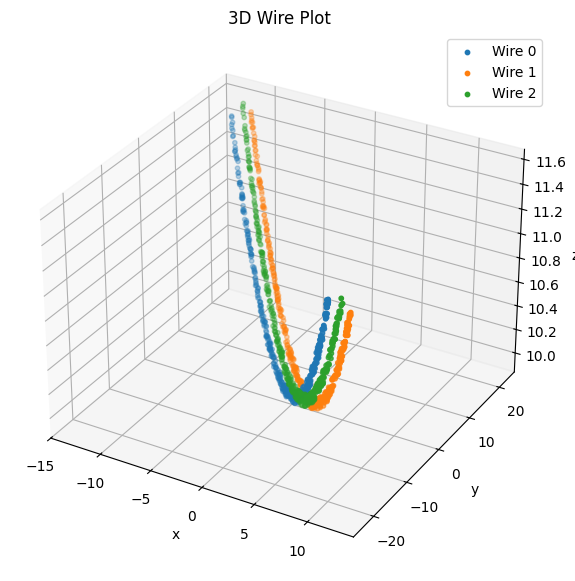

In [357]:
from lidar_functions.plot_functions import plot_3d_wire_clusters

plot_3d_wire_clusters(combined_lidar)

## Getting the plane equations parallel to each wire

In [358]:
from lidar_functions.vector_functions import get_best_plane

best_planes = []
point_origins = []

for i in range(len(combined_lidar.global_wire.unique())):

    wire_points = combined_lidar[combined_lidar['global_wire'] == i][['x', 'y', 'z']]
    
    best_plane, point_origin = get_best_plane(wire_points) 
    point_origins.append(point_origin)
    best_planes.append(best_plane)
    
    print(f"Best Plane Equation for Wire {i}: {best_plane[0]:.3f}x + {best_plane[1]:.3f}y + {best_plane[2]:.3f}z + {best_plane[3]:.3f} = 0")


Best Plane Equation for Wire 0: 66.500x + 36.249y + 26.805z + -202.914 = 0
Best Plane Equation for Wire 1: 64.082x + 35.025y + 16.458z + -228.504 = 0
Best Plane Equation for Wire 2: 67.063x + 36.683y + 12.319z + -124.759 = 0


In [359]:
from lidar_functions.vector_functions import get_2d_points

all_points = []

for i in range(len(combined_lidar.global_wire.unique())):
    
    points_2d = get_2d_points(combined_lidar[combined_lidar['global_wire'] == i][['x', 'y', 'z']], 
                              best_planes[i], 
                              point_origins[i])
    all_points.append(points_2d)

In [360]:
# Assuming and setting up the y-value such that it is 10 units above ground
for line in all_points:

    y = line[:, 1]
    y_min = y.min()
    
    line[:, 1] = y - y_min + 10

### Finding the best C to find the optimal catenary equation

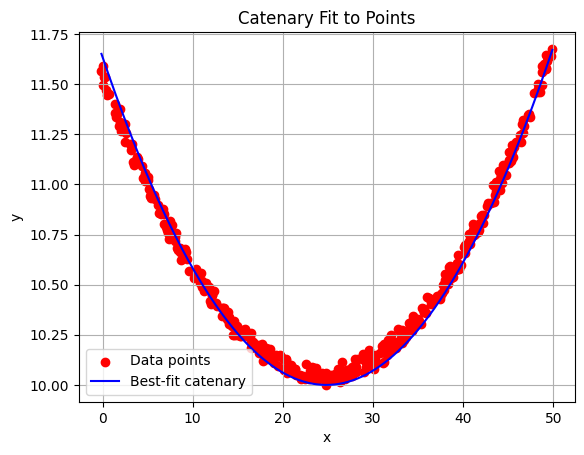

Wire 1: y(x) = 10.0 + 188.65642314205232 * [cosh((x - 24.819930019678267) / 188.65642314205232) - 1]


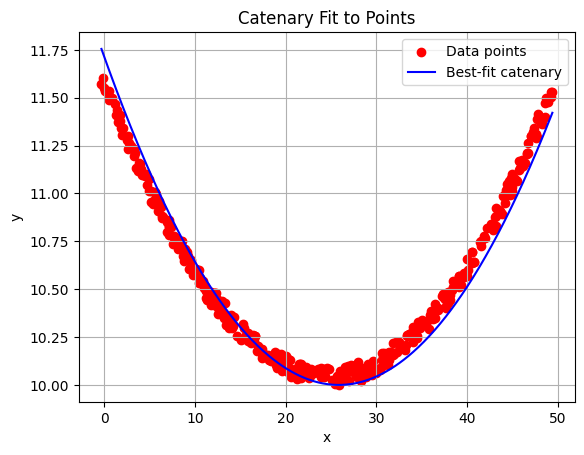

Wire 2: y(x) = 10.0 + 195.27712595420834 * [cosh((x - 25.853176241666247) / 195.27712595420834) - 1]


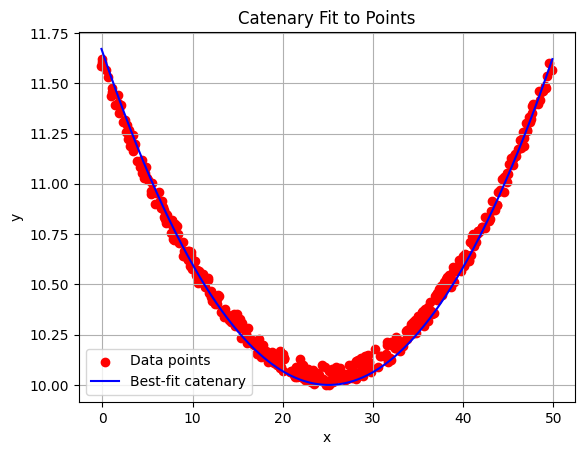

Wire 3: y(x) = 10.0 + 190.34980493146267 * [cosh((x - 25.08373128371672) / 190.34980493146267) - 1]


In [ ]:
from scipy.optimize import minimize
from lidar_functions.optimise_functions import find_param, catenary, loss

for i in range(len(combined_lidar.global_wire.unique())):

    x0, y0 = find_param(all_points[i])

    initial_c = 10

    res = minimize(lambda c: loss(c, all_points[i], x0, y0), x0=initial_c, bounds=[(0.1, None)])  

    best_c = res.x[0]

    x_vals = np.linspace(all_points[i][:, 0].min(), all_points[i][:, 0].max(), 500)

    y_vals = catenary(x_vals, y0, best_c, x0)

    plt.scatter(all_points[i][:, 0], all_points[i][:, 1], color='red', label='Data points')

    plt.plot(x_vals, y_vals, color='blue', label='Best-fit catenary')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Catenary Fit to Points')
    plt.grid(True)
    plt.show()

    print(f"Wire {i + 1}: y(x) = {y0} + {best_c} * [cosh((x - {x0}) / {best_c}) - 1]")